# Easy 21 Reinforcement Learning

In this notebook, we are going to implement a Monte Carlo learning agent and a SARSA agent to play Easy 21, which is a modified version of blackjack. The rules for Easy 21 are as follows:
- Red and Black cards ranging from 1-10 in value
- Black cards are added to score, Red cards are subtracted from score
- Black cards occur with 2/3 probability, Red cards with 1/3 probability
- Agent and Dealer each start with 1 black card (agent can see dealer's card)
- Player can hit or stick on turn, once player sticks turn is over
- Agent goes first, then dealer
- Player with high score wins (bust if score > 21 or < 1)

(from: https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf)

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

### Initialization
First we need to set up our Agent class, which will play Easy 21 against a "dealer" who hits if he has between 1 and 17 and sticks otherwise. We will have an Agent base class from which the Monte Carlo agent and SARSA Agent will inherit. The Agent class will hold all of the common functionality between the two which includes:  
&nbsp;&nbsp;&nbsp;&nbsp;**step()** - the agent either hits and is dealt a card, or sticks and we play out the remainder of the dealer's turn  
&nbsp;&nbsp;&nbsp;&nbsp;**choose_action()** - follow the current policy with probability 1 - $\epsilon$ and explore (hit or stick randomly) with probability $\epsilon$   
&nbsp;&nbsp;&nbsp;&nbsp;**is_terminal()** - Evaluates whether the agent or dealer has gone bust, or whether the agent has chosen to stick and the dealer has 17 or higher
&nbsp;&nbsp;&nbsp;&nbsp;**give_reward()** - Gives the agent a reward of 1 for a win, 0 for a non-terminal state or tie, and -1 for a loss

We also define several functions to run the agent after training is complete and to plot the agent's value function and the results of a run. Finally we define a helper function, **deal_card()** to facilitate gameplay. 

In [2]:
class Agent:
    def __init__(self, epsilon):
        '''
        params:
                epsilon - exploration parameter
                stick - boolean used to help determine if state is terminal
                values - action/value approximation
                running_total - agent score, used to calculate statistics for training runs
                policy - agent's preference (hit/stick) in each state (agent sum, dealer card)
        '''
        self.epsilon = epsilon
        self.stick = False
        self.values = np.zeros((21, 10, 2))
        self.running_total = [0]
        self.policy = [[0 for i in range(10)] for i in range(21)]
        
    def step(self, state, action):
        '''
        If player hits (0), deal card.  
        If player sticks (1), play out the dealer's turn
        '''
        if action == 0:
            state[0] += deal_card(False)
        else:
            self.stick = True
            while state[1] < 17 and state[1] >= 1:
                state[1] += deal_card(False)

        return self.give_reward(state)
    
    def choose_action(self, state):
        greedy = np.random.random()
        if greedy > self.epsilon:
            action = self.policy[state[0] - 1][state[1] - 1]
        else:
            action = np.random.randint(2)
        return action
    
    def is_terminal(self, state):
        '''
        Returns true if game is over (both players stick or one player goes bust), false otherwise
        '''
        if state[0] > 21 or state[0]< 1:
            return True

        elif self.stick and (state[1] >= 17 or state[1] < 1):
            return True

        return False
    
    def give_reward(self, state):
        '''
        Reward = +1 (win), -1 (loss), 0 (tie or non-terminal state)
        '''
        if self.is_terminal(state):
            if state[0] > 21 or state[0] < 1:
                self.running_total.append((self.running_total[-1] - 1))
                return -1
            elif state[1] > 21 or state[1] < 1:
                self.running_total.append((self.running_total[-1] + 1))
                return 1
            elif state[0] > state[1]:
                self.running_total.append((self.running_total[-1] + 1))
                return 1
            elif state[0] < state[1]:
                self.running_total.append((self.running_total[-1] - 1))
                return -1
        return 0

    def value_function(self):
        '''
        Return expected reward for each state (agent sum, dealer card)
        '''
        
        value_function = np.zeros((21,10))
        for i in range(len(self.values)):
            for j in range(len(self.values[i])):
                value_function[i][j] = np.max(self.values[i][j])
        return value_function
    
    def testing_run(self, num_episodes):
        self.epsilon = 0
        self.running_total = [0]
        for i in range(num_episodes):
            self.stick = False
            state = [deal_card(True), deal_card(True)]
            while not self.is_terminal(state):
                action = self.choose_action(state)
                reward = self.step(state, action)
    
    def plot_returns(self):
        episodes = np.array([i for i in range(0, len(self.running_total))])
        plt.plot(episodes[1000:], self.running_total[1000:])
        plt.xlabel("Number of Episodes")
        plt.ylabel("Total Winnings")
        plt.show()
    
    def plot_value_function(self):
        '''
        plotting function from: https://github.com/mari-linhares/easy21/blob/master/easy21.ipynb
        '''
        fig = plt.figure("Value Function", figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')

        min_x = 1
        max_x = 10
        min_y = 1
        max_y = 21

        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        X, Y = np.meshgrid(x_range, y_range)
    
        def get_stat_val(x, y):
            return self.value_function()[y, x]
        
        Z = get_stat_val(X, Y)

        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                                   linewidth=0, antialiased=False)

In [3]:
def deal_card(is_first):
    '''
    First card for dealer and agent is black (positive value),
    for subsequent cards prob(black) = 2/3, prob(red) = 1/3
    '''
    value = np.random.randint(1,11)
    if is_first:
        return value
    else:
        color = np.random.random()
        if color < .33:
            value = 0 - value
        return value

## Monte Carlo Agent
Monte Carlo learning is a type of model-free learning. Our Monte Carlo agent does not attempt to learn anything about the probability of transitioning between pairs of states. It simply tracks its average reward received from each action sequence. An action sequence here is a start state, an action (hit or stick), a reward, and the resulting next state. The Monte Carlo agent updates its value function with the following formula:  
$Q(s,a) = \text{avg_return}(s,a)$   
This is simply learning from experience - over time the agent will learn whether hitting or sticking tends to yield higher reward for each state (player sum, dealer showing). Since Easy 21 involves a good bit of chance, both hitting and sticking may have negative average reward (picture yourself dealt a 14 in blackjack with the dealer showing an ace) so the agent will pick the most positive or least negative action in each state.  
The Monte Carlo agent takes a parameter $\epsilon$, which is the probability that it chooses a random action rather than the one dictated by its policy at any given step. This allows the agent to explore more paths than it otherwise would and better build a more robust value function. As the training run goes on, we gradually decrease $\epsilon$ so the agent chooses the "best" action more frequently. In the testing run we will set $\epsilon$ to 0 so the agent will only follow its policy in any state.

In [4]:
class MonteCarloAgent(Agent):
    '''
    params:
            epsilon - likelihood that agent chooses random action (hit/stick) rather than action dictated by policy
    '''
    def __init__(self, epsilon):
        super().__init__(epsilon)
    
    def training_run(self, num_episodes):
        '''
        ε starts high to encourage exploration, steadily decreases as agent 
        learns better value approximations.  Policy starts as "hit" in every state, 
        becomes ε-greedy w.r.t. value function.
        '''
        returns = [[[[],[]] for i in range(10)] for i in range(21)]

        for i in range(num_episodes):
            self.stick = False
            self.epsilon *= .9999
            G = 0
            state = [deal_card(True), deal_card(True)]
            while not self.is_terminal(state):
                last_state = deepcopy(state)
                action = self.choose_action(state)
                reward = self.step(state, action)
                G += reward
                returns[last_state[0] - 1][last_state[1] - 1][action].append(G)

                self.values[last_state[0] - 1][last_state[1] - 1][action] = \
                    np.average(returns[last_state[0] - 1][last_state[1] - 1][action])

                self.policy[last_state[0] - 1][last_state[1] - 1] = \
                    np.argmax(self.values[last_state[0] - 1][last_state[1] - 1])

## Training Run
We will run the agent through 200,000 games for its training run. We start with a very high epsilon to encourage exploration, and gradually increase the frequency with which our agent chooses the "best" action throughout the run. Afterwards we can plot the value function to see what the agent's expected return in each state is. Note that as the agent's total approaches 21, its expected reward approaches 1 and as the dealer's card increases, the agent's expected reward decreases.

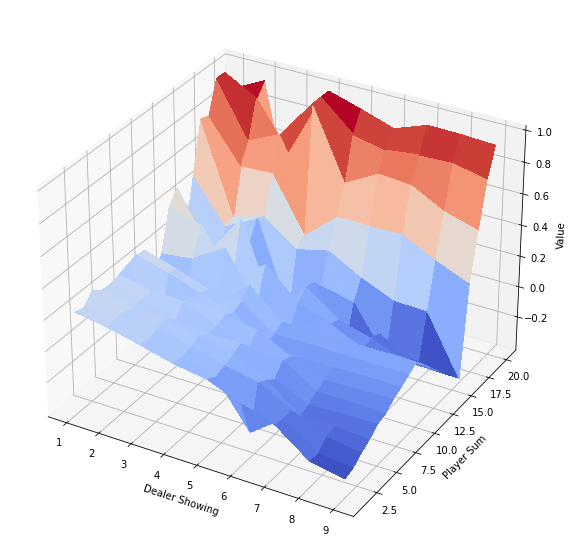

In [5]:
mc_agent = MonteCarloAgent(.9999)
mc_agent.training_run(200000)
mc_agent.plot_value_function()

## Testing Run
Now let's test our Monte Carlo agent and see how it performs over 100,000 runs. The agent will only follow its policy during testing, which means it will pick the action it believes will bring the greatest reward in each state. The plot shows the agent's total winnings over the course of the run. The Monte Carlo agent ends up ahead by about 3500 games over the testing run. This means it wins about 52% of the time, which is a big edge in a game of mostly luck and where the dealer is playing intelligently!

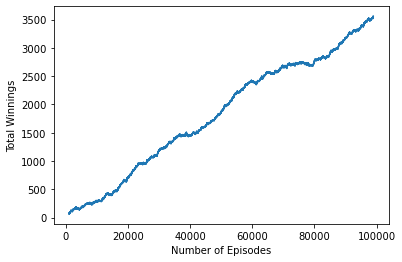

In [6]:
mc_agent.testing_run(100000)
mc_agent.plot_returns()

## SARSA Agent
SARSA stands for State-Action-Reward-State-Action, and is a form of Temporal Difference learning. Rather than waiting to receive the actual reward at the end of each game like the Monte Carlo agent, our SARSA agent will update its belief about its expected reward at each step. The update SARSA makes at each step is:  
$Q(s_t, a_t) = Q(s_t, a_t) + \alpha(r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$  
Where $Q(s_t, a_t)$ is the value function for the state-action pair $(s_t, a_t)$, $\alpha$ is the learning rate, or how heavily to value new information, and $\gamma$ is the discount rate, or how heavily to weight future vs. current rewards. Just like the Monte Carlo agent, the SARSA agent has a parameter $\epsilon$ to encourage exploration early in the training run.

In [7]:
class SARSA_Agent(Agent):
    '''
    params:
            alpha - agent's learning rate
            gamma - agent's discount factor
    '''
    def __init__(self, epsilon, alpha, gamma):
        super().__init__(epsilon)
        self.alpha = alpha
        self.gamma = gamma
    
    def training_run(self, num_episodes):
        '''
        Action/value approximation: Q(s,a) = Q(s,a) + α(reward + γQ(s',a') - Q(s,a))
        '''
        for i in range(num_episodes):
            self.stick = False
            state = [deal_card(True), deal_card(True)]
            action = self.choose_action(state)
            while not self.is_terminal(state):
                last_state = deepcopy(state)
                last_action = action
                reward = self.step(state, action)

                if not self.is_terminal(state):
                    action = self.choose_action(state)
                    self.values[last_state[0] - 1][last_state[1] - 1][last_action] += \
                        (self.alpha * (reward + (self.gamma * \
                        self.values[state[0] - 1][state[1] - 1][action]) - \
                        self.values[last_state[0] - 1][last_state[1] - 1][last_action]))
                else:
                    self.values[last_state[0] - 1][last_state[1] - 1][last_action] += \
                        (self.alpha * (reward - \
                        self.values[last_state[0] - 1][last_state[1] - 1][last_action]))

                self.policy[last_state[0] - 1][last_state[1] - 1] = \
                    np.argmax(self.values[last_state[0] - 1][last_state[1] - 1])

## Training Run
Let's take the SARSA agent through the same 200,000 episode training run as the Monte Carlo agent and use .1 as the learning rate and .9 as the discount rate. This means the agent will be somewhat cautious about updating its beliefs (only giving 10% weight to new information) and mostly focused on future reward (with a discount rate of 90%). The SARSA agent's value function looks similar to the Monte Carlo agent's but is a bit more jagged. This is likely because the Monte Carlo agent's value function reflects the ground truth (what actually happened), whereas the SARSA agent's value function is based on estimates. Later we will compare the value functions of the two and determine the Mean Squared Error of the SARSA agent.

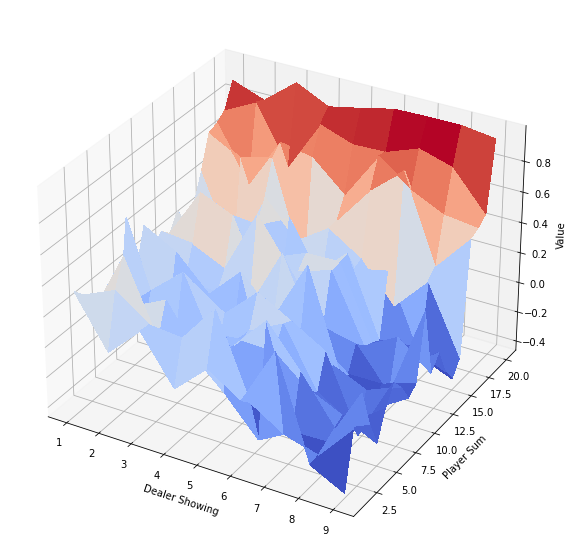

In [8]:
sarsa_agent = SARSA_Agent(.9999, .1, .9)
sarsa_agent.training_run(200000)
sarsa_agent.plot_value_function()

## Testing Run
The SARSA agent also performs well, winning about 2500 more games than it loses. This is a winning percentage of around 51% which means it is also beating a dealer that is playing intelligently (remember the dealer is following "house rules" where it hits if it holds less than 17 and sticks otherwise)!

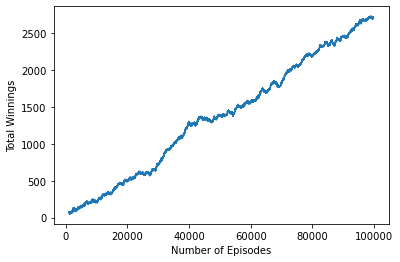

In [9]:
sarsa_agent.testing_run(100000)
sarsa_agent.plot_returns()

## Mean Squared Error of SARSA Agent Value Function
Why did the SARSA agent not perform as well as the Monte Carlo agent? Likely because the Monte Carlo agent was basing its updates on the actual results, while the SARSA agent was keeping an approximation. This allows the SARSA agent to learn quicker and potentially evaluate more states, but prevents it from achieving the same level of performance. We can compute the Mean-Squared Error of the SARSA agent (taking the Monte Carlo agent's value function as ground truth) with the following formula:  
$MSE = \Sigma((Q(s,a)_{SARSA} - Q(s,a)_{Monte Carlo})^2$  

In [10]:
def compute_MSE(mc_agent, sarsa_agent):
    return np.sum((mc_agent.values - sarsa_agent.values)**2)

In [11]:
print(compute_MSE(mc_agent, sarsa_agent))

21.245107735811494
